In [3]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision import transforms as tfs
from torch.utils.data import DataLoader
import torchvision
import numpy as np

# Defined datasets and dataloaders
##### - we first set some transforms for batch normalization of data

In [4]:
batch_size = 64 if torch.cuda.is_available() else 16

transforms = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.4914, 0.4822, 0.4465),
                  (0.247, 0.2435, 0.2616))
])

train_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=True,
    transform=transforms,
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


test_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=False,
    transform=transforms,
)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


<>:10: SyntaxWarning: invalid escape sequence '\K'
<>:20: SyntaxWarning: invalid escape sequence '\K'
<>:10: SyntaxWarning: invalid escape sequence '\K'
<>:20: SyntaxWarning: invalid escape sequence '\K'
C:\Users\ahmad\AppData\Local\Temp\ipykernel_17240\997862762.py:10: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',
C:\Users\ahmad\AppData\Local\Temp\ipykernel_17240\997862762.py:20: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',


# Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


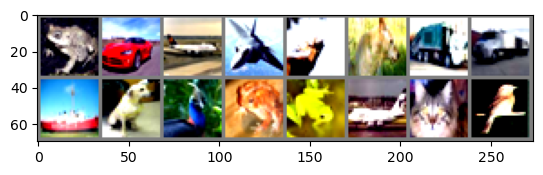

frog  car   plane plane deer  dog   truck truck ship  dog   bird  frog  frog  plane cat   bird 


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# functions for showing an image :
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# Define The Neural Network

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.stack = nn.Sequential(
            # Convolutional Neural Network
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16,  5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Flat the data for Fully Connected Networks (2d -> 1d)
            nn.Flatten(),

            # Fully Connected Network
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
        )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits


# Define a device and optimizer and loss function (criterion)

In [15]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cpu device


In [16]:
model = NeuralNetwork().to(device)

In [17]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Define function for training

In [18]:
def train_set(model, optim, device, criterion, train_dataloader):
    running_loss, correct = 0, 0
    model.train()
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        running_loss += loss.item()
        correct += (y_pred.argmax(1) == y).type(torch.float64).sum().item()
    
    return running_loss / len(train_dataloader), (correct / len(train_dataloader.dataset)) * 100

# time to train datas.

In [19]:
def train_data(model, optim, device, criterion, train_dataloader, epochs):
    train_losses, train_accs = [], []
    for epoch in range(1, epochs):
        train_loss, train_acc = train_set(model, optim, device, criterion, train_dataloader)
        print(f"Epoch {epoch} / {epochs} => loss : {train_loss:.3f} ; accuracy : {train_acc:.3f} ")
        train_losses.append(train_loss)
        train_accs.append(train_accs)
    return train_losses, train_accs

#### now we have writed a function to train the model on training datas; if the results were good enough and we were certain of it, we are allowed to use test datas to see if our model fitted well on the dataset.

# Function for test data.

In [20]:
def test_set(model, device, criterion, test_dataloader):
    running_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            running_loss += loss.item()
            correct += (y_pred.argmax(1) == y).type(torch.float64).sum().item()
    return running_loss / len(test_dataloader), (correct / len(test_dataloader.dataset)) * 100
    
            

# Final Evaluation

In [21]:
def test_data(model, device, criterion, test_dataloader):
    test_loss, test_acc = test_set(model, device, criterion, test_dataloader)
    print(f"model tested on final datas => loss : {test_loss:.3f} ; accuracy : {test_acc:.3f}")

In [22]:
history = train_data(model, optim, device, criterion, train_dataloader, 8)

Epoch 1 / 8 => loss : 1.629 ; accuracy : 40.012 
Epoch 2 / 8 => loss : 1.547 ; accuracy : 43.538 
Epoch 3 / 8 => loss : 1.681 ; accuracy : 37.944 
Epoch 4 / 8 => loss : 2.130 ; accuracy : 18.848 
Epoch 5 / 8 => loss : 2.312 ; accuracy : 10.086 
Epoch 6 / 8 => loss : 2.310 ; accuracy : 9.936 
Epoch 7 / 8 => loss : 2.310 ; accuracy : 9.954 
